<a href="https://colab.research.google.com/github/mandeebot/Data_cleaning/blob/main/Wrangle_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA WRANGLING AND ANALYSIS**
**Introduction**

The dataset that we will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

###Data Description

 - **Enhanced Twitter Archive:** 
The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, I have filtered for tweets with ratings only (there are 2356).

- **Additional Data via the Twitter API:**
Back to the basic-ness of Twitter archives: retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API. Well, "anyone" who has access to data for the 3000 most recent tweets, at least. But you, because you have the WeRateDogs Twitter archive and specifically the tweet IDs within it, can gather this data for all 5000+. And guess what? You're going to query Twitter's API to gather this valuable data.

- **Image Predictions File:**
One more cool thing: I ran every image in the WeRateDogs Twitter archive through a neural network that can classify breeds of dogs*. The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

# **Data Wrangling**
- Data gathering,
- Assesing
- Cleaning
- Exploratory Analysis 


In [523]:
#importing requried libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
import os
import datetime

import bs4 as bs

# **DATA GATHERING**
in this section, we will be gathering 3 different data from 3 sources;
- Reading in the provided twitter archive data
- Downloading the image predictions data from a server
- Querying the twitter API for addional twitter data  

In [524]:
#reading in the twitter_archive data provided by udacity
ut_archive = pd.read_csv('/content/drive/MyDrive/udac_proj/project2/twitter-archive-enhanced.csv') 

In [525]:
#downloading the image predictions file programmatically 
import requests


url =  'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

# Check if the request was successful, and print some info
print("Status-code: {}".format(r.status_code))
print("Encoding: {}".format(r.encoding))


Status-code: 200
Encoding: utf-8


In [526]:
with open(os.path.join('',url.split("/")[-1]),mode='wb') as file:
  file.write(r.content)


ipred_data = pd.read_csv(url.split('/')[-1],sep='\t')

In [527]:
#fetching extended data from the twitter API
import tweepy
import json
from timeit import default_timer as timer # for setting up a timer

# Twitter App access keys
CONSUMER_KEY = ' '
CONSUMER_SECRET = ' '
ACCESS_TOKEN = ' '
ACCESS_SECRET = ' '

# Authentication and access using keys:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

# Return API with authentication:
api = tweepy.API(auth)

In [528]:
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = ut_archive.tweet_id.values
len(tweet_ids)

2356

In [529]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()

# Store each tweet's entire set of JSON data in a file called tweet_json.txt
with open('tweet_json.txt', 'w') as tweet_file:
    #for loop to query and collect the required json data on a text file(tweet_json)
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for id in tweet_ids:
        count += 1
        #print(str(count) + ": " + str(id))
        try:
            tweet = api.get_status(id, tweet_mode='extended')
            #print("Success")
            json.dump(tweet._json, tweet_file)
            tweet_file.write('\n')
        except tweepy.TweepError as e:
            #print("Fail")
            fails_dict[id] = e
            pass

In [530]:
#now we read in the saved json data collected via the api and create a dataframe
data = []
with open('tweet-json.txt',mode='r') as file:
     #Read in JSON line and convert to dict
     json_line = file.readline()
    # Read line by line into a dataframe
     while json_line:
        line = json.loads(json_line)
        data.append(line)
        # Read a JSON line and convert it to a dictionary
        json_line = file.readline()
#create a dataframe
ext_data = pd.DataFrame(data)
ext_data = ext_data[['id','favorite_count','retweet_count']]

# **ASSESSING DATA**
In this section, we assess the datasets we gathered to identify and highlight  data quality and tidiness issues, this is also an excellent way to understand the data that we have acquired

In [531]:
pd.set_option('display.max_colwidth', 199)

In [532]:
ut_archive.shape

(2356, 17)

In [533]:
#start of by assessing the tweeter acvive data
ut_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None


In [534]:
ut_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [535]:
ut_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [536]:
#lets check for duplicates
ut_archive.duplicated().sum()

0

In [537]:
#checking for missing values
ut_archive.isna().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [538]:
#wrong data type
type(ut_archive.timestamp[0])

str

In [539]:
#messy & untidy data 
ut_archive.text[0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

In [540]:
#messy & untidy data
ut_archive.source[12]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [541]:
#structural issue
ut_archive[['doggo','floofer','pupper','puppo']].value_counts()

doggo  floofer  pupper  puppo
None   None     None    None     1976
                pupper  None      245
doggo  None     None    None       83
None   None     None    puppo      29
doggo  None     pupper  None       12
None   floofer  None    None        9
doggo  None     None    puppo       1
       floofer  None    None        1
dtype: int64

In [542]:
ipred_data.shape

(2075, 12)

In [543]:
ipred_data.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [544]:
ipred_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [545]:
ipred_data.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [546]:
#identifying data duplicates
ipred_data.duplicated().sum()

0

In [547]:
#identifying missing data
ipred_data.isna().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [548]:
#messy data
print(ipred_data.p1.head(2))
print(ipred_data.p2.head(2))
print(ipred_data.p3.head(2))

0    Welsh_springer_spaniel
1                   redbone
Name: p1, dtype: object
0                collie
1    miniature_pinscher
Name: p2, dtype: object
0      Shetland_sheepdog
1    Rhodesian_ridgeback
Name: p3, dtype: object


In [549]:
#identifying irrelevant feature
ipred_data.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [550]:
#Identifying the false dogs predictions in the dataset
false_predictions = ~((ipred_data.p1_dog) | (ipred_data.p2_dog) | (ipred_data.p3_dog))
false_predictions_dog = ipred_data[false_predictions].index.tolist()
ipred_data[false_predictions].head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False


In [551]:
ext_data.shape

(2354, 3)

In [552]:
ext_data.head()

,id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774


In [553]:
ext_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   favorite_count  2354 non-null   int64
 2   retweet_count   2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [554]:
ext_data.duplicated().sum()

0

In [555]:
ext_data.isna().sum()

id                0
favorite_count    0
retweet_count     0
dtype: int64

In [556]:
ext_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2354.0,7.426978e+17,6.852812e+16,6.660209e+17,6.783975e+17,7.194596e+17,7.993058e+17,8.924206e+17
favorite_count,2354.0,8.080969e+03,1.181477e+04,0.000000e+00,1.415000e+03,3.603500e+03,1.012225e+04,1.328100e+05
retweet_count,2354.0,3.164797e+03,5.284770e+03,0.000000e+00,6.245000e+02,1.473500e+03,3.652000e+03,7.951500e+04


**observations**

from assessing this data set, we are able to identify as couple of structuaral and data quality issues
- the timestamp column is not in the right data structure (should be a timestamp object not a string
- we can see we clearly have a lot of missing values,in columns; in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_user_id,retweeted_status_timestamp (more than 80% of the data is missing) and the expanded_urls feature(having less than 5% missing in this case)
-the name feature seems to be inconsistency in the names, that ought to be fixed
- we can also observe some messyness in the text columns, where we have links attached to the text, as well as the rating too. the column should ideally hold only text
- we can also observe that in the source feature, we have html tags enclosing the source. this ought not be the case
- the last four columns indicate the dog type, all of that info can be represented in a single column, there also appears to be alot of None values, so roughly 60% of the values are None
- there appears to be redundant features in the dataset, for instance that are irrelevant for our analysis 
- in the image predictions dataset, specifically in the p1,p2p3 columns, there appears to be an underscore making the feature messy, that ought not to be the case
- the image number feature in the image predictions data set seems irrelevant to the analysis as such should be dropped 
- Not all model predictions are accurate
- the p1,p2,p3 and their corresponding model coefficient values, the best predictions among the three should be used as the main predictions feature, while the other two dropped

# **DATA CLEANING**

in this stage, we will merge all three datasets into 1, and address all the tidiness issues we have identified in the assesing stage

In [557]:
#hanging the extracted data's id to tweet_id
ext_data.rename(columns={'id':'tweet_id'},inplace=True)

In [558]:
#merging the datasets into one master dataframe
from functools import reduce

dfs = [ut_archive, ipred_data, ext_data]
master_df = reduce(lambda left,right: pd.merge(left,right,on='tweet_id', how='inner'), dfs)

In [559]:
master_df.shape

(2073, 30)

In [560]:
master_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,39467,8853
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,33819,6514


In [561]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2073 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2073 non-null   object 
 4   source                      2073 non-null   object 
 5   text                        2073 non-null   object 
 6   retweeted_status_id         79 non-null     float64
 7   retweeted_status_user_id    79 non-null     float64
 8   retweeted_status_timestamp  79 non-null     object 
 9   expanded_urls               2073 non-null   object 
 10  rating_numerator            2073 non-null   int64  
 11  rating_denominator          2073 non-null   int64  
 12  name                        2073 non-null   object 
 13  doggo                       2073 

In [562]:
# start off by fixing wrong data type issues
#change master_df.timestamp feature datatype from string to datetime 
master_df.timestamp = pd.to_datetime(master_df.timestamp)

#test
master_df.timestamp[0].hour

16

In [563]:
#now lets address the messy issues
#removing the html tags on the source data points
master_df.source = master_df[['source']].applymap(lambda text: bs.BeautifulSoup(text, 'html.parser').get_text())

#test
master_df.source[1000]  

'Twitter for iPhone'

In [564]:
#cleaning text column by seperating the links and putting them in another column
links = []
for x in master_df.text:
  links.append(x.split()[-1])
  #links.append(x)#cleaned_archive['links'] = links
master_df['links'] = links

master_df['links'][:3]


0    https://t.co/MgUWQ76dJU
1    https://t.co/0Xxu71qeIV
2    https://t.co/wUnZnhtVJB
Name: links, dtype: object

In [565]:
#cleaning the text column by removing any other characters apart from strings
ee = []
ss = []
#ss.append(' '.join((lambda x : x.split()[:-1]))
for x in master_df.text:
  ss.append(x.split()[:-1])
  for d in ss:
    q = ' '.join(d)
  if ee != q:
    ee.append(q)

master_df.text = ee
master_df.text.str.replace('\d+', '')

#test
master_df.text[:3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]


0                                                         This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10
1    This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10
2                     This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10
Name: text, dtype: object

In [566]:
#cleaning the inconsistency in the names column by capitalizing every lowered case name
master_df.name.apply(lambda x: x.title())

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2068        None
2069           A
2070           A
2071           A
2072        None
Name: name, Length: 2073, dtype: object

In [567]:
#the dog type information should all be represented in one column
master_df['dog_type'] = master_df[['doggo', 'floofer','pupper','puppo']].apply(lambda x: ', '.join(x), axis=1)
master_df = master_df.replace(regex=r'(None,? ?)', value='').replace(regex=r'(, $)', value='')
master_df.drop(['doggo', 'floofer','pupper','puppo'], axis=1,inplace=True)
master_df = master_df.replace(regex=r'', value= np.nan)

#test
master_df['dog_type'].value_counts()

pupper            210
doggo              67
puppo              23
doggo, pupper      11
floofer             7
doggo, puppo        1
doggo, floofer      1
Name: dog_type, dtype: int64

In [568]:
#Identifying the false dogs predictions in the dataset
wrong_predictions = ~((master_df.p1_dog) | (master_df.p2_dog) | (master_df.p3_dog))
wrong_predictions_dog = master_df[false_predictions].index.tolist()

#dropping off the falsly predicted data points
master_df.drop(wrong_predictions_dog, inplace = True)
master_df = master_df.reset_index(drop = True)

#test
master_df.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,links,dog_type
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,...,bagel,0.085851,False,banana,0.076110,False,39467,8853,https://t.co/MgUWQ76dJU,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,...,Pekinese,0.090647,True,papillon,0.068957,True,33819,6514,https://t.co/0Xxu71qeIV,NaN


In [569]:
# Remove irrelevant features/columns with more than 70% of the data points, missing
master_df.drop(['in_reply_to_user_id','in_reply_to_status_id','retweeted_status_id',
                      'retweeted_status_user_id', 'retweeted_status_timestamp','dog_type'], axis = 1, inplace = True)

In [570]:
#removing irrelevant columns
master_df.drop(['expanded_urls','img_num','name'],axis=1,inplace=True)

In [571]:
#feature engineering; creating a master dog's prediction column
columns = ['p1_dog','p2_dog','p3_dog']
pred = []
preds = []

for index in range(master_df.shape[0]):
    for col in columns:
        if master_df.loc[index,col] == True:
            pred.append(col)
    try:
      preds.append(pred)
    except:
      pred = []

In [572]:
mapping_col = {'p1_dog': ['p1','p1_conf'], 'p2_dog': ['p2','p2_conf'], 'p3_dog': ['p3','p3_conf']}
predictions = []
conf1 = []


for index in range(master_df.shape[0]):
    predictions.append(master_df.loc[index,mapping_col[preds[index][0]][0]])
    conf1.append(master_df.loc[index,mapping_col[preds[index][0]][1]])

master_df['model_predictions'] = pd.Series(predictions)
master_df['confidence_leve']  = pd.Series(conf1)
master_df.drop(['p1','p2','p3','p1_dog','p1_conf','p2_dog','p2_conf','p3_dog','p3_conf'],axis=1,inplace=True)

#test
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1750 non-null   int64              
 1   timestamp           1750 non-null   datetime64[ns, UTC]
 2   source              1750 non-null   object             
 3   text                1750 non-null   object             
 4   rating_numerator    1750 non-null   int64              
 5   rating_denominator  1750 non-null   int64              
 6   jpg_url             1750 non-null   object             
 7   favorite_count      1750 non-null   int64              
 8   retweet_count       1750 non-null   int64              
 9   links               1750 non-null   object             
 10  model_predictions   1750 non-null   object             
 11  confidence_leve     1750 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64

In [573]:
master_df.isna().sum()

tweet_id              0
timestamp             0
source                0
text                  0
rating_numerator      0
rating_denominator    0
jpg_url               0
favorite_count        0
retweet_count         0
links                 0
model_predictions     0
confidence_leve       0
dtype: int64

In [574]:
master_df.duplicated().sum()

0

After the cleaning the excersis, our data set is pretty clean now,(still a couple of issues too be addressed though), Now we save the already cleaned dataset as a csv file.

In [575]:
master_df.to_csv('cleaned_data')

# EXPLORATORY ANALYSIS
In this section using visualizations, we exlore our cleaned dataset for insights and any information we may find useful

In [576]:
master_df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'jpg_url', 'favorite_count', 'retweet_count',
       'links', 'model_predictions', 'confidence_leve'],
      dtype='object')

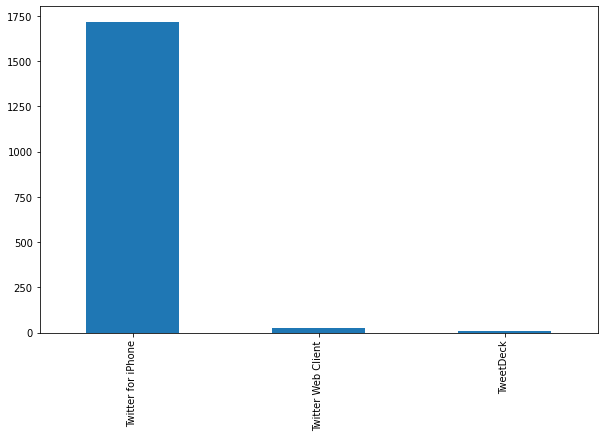

In [577]:
plt.figure(figsize=(10,6))
master_df.source.value_counts().plot(kind='bar')

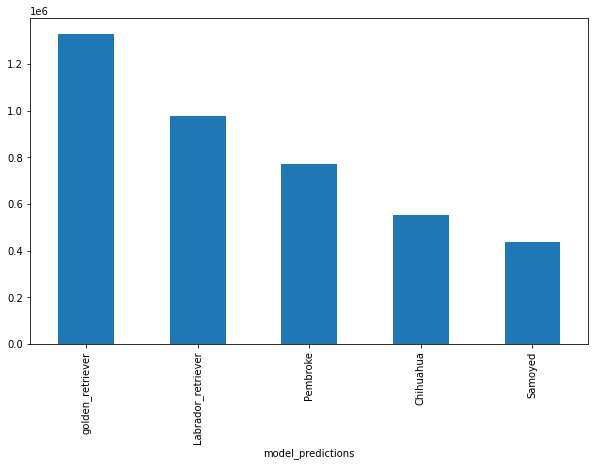

In [578]:
plt.figure(figsize=(10,6))
master_df.groupby('model_predictions')['favorite_count'].sum().sort_values(ascending=False).head().plot(kind='bar');

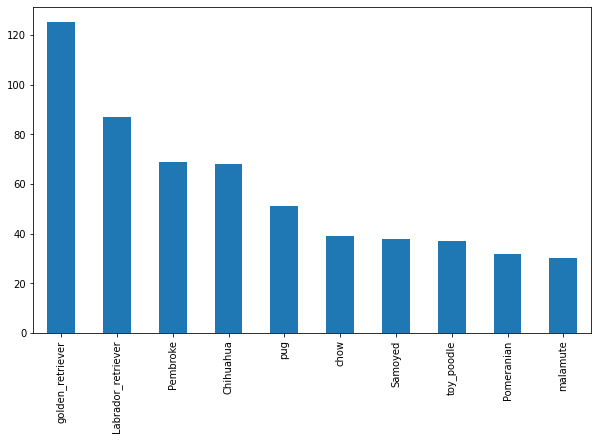

In [579]:
plt.figure(figsize=(10,6))
master_df['model_predictions'].value_counts().head(10).plot(kind='bar');

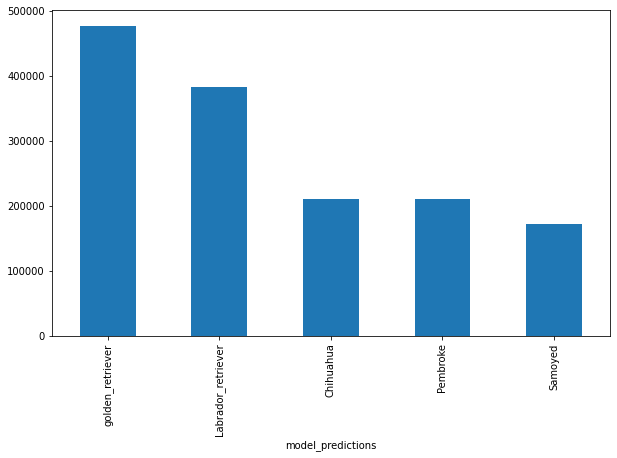

In [580]:
plt.figure(figsize=(10,6))
master_df.groupby('model_predictions')['retweet_count'].sum().sort_values(ascending=False).head().plot(kind='bar');

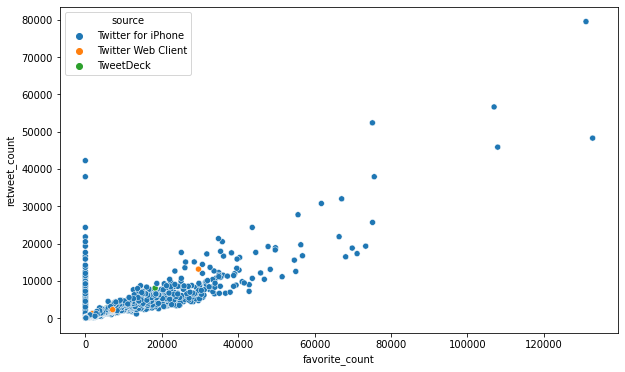

In [581]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.scatterplot(x='favorite_count',y='retweet_count',hue='source',data=master_df);